# Results Reproducibility (Experiments under Gaussian noise and blur)

You can reproduce our paper results following this notebook.

Please, make sure to replace `image_test.jpg`  with you own image.

also to run this code, libraries should be installed from `pip install -r requirements.txt`

### 1- Importing necessary libraries

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from similarity_metrics.ssim_rmse_psnr_metrics import rmse, psnr, ssim
from similarity_metrics.fsim_quality import FSIMsimilarity
from similarity_metrics.issm_quality import ISSMsimilarity
from CopulaSimilarity.CSM import CopulaBasedSimilarity as CSMSimilarity
import pickle

from skimage.metrics import structural_similarity as ssim

Image resolution: 3888x2592


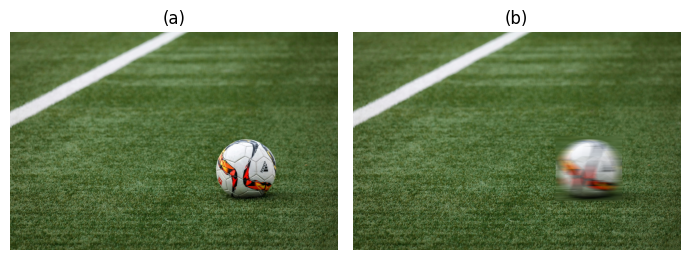

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = 'examples/ball.jpg'
image = cv2.imread(image_path)

# Print the resolution of the image
height, width, _ = image.shape
print(f"Image resolution: {width}x{height}")

# Manual coordinates of the ball in the image
x1, y1 = 2402, 1244
x2, y2 = 3191, 2010

# Extract the region of interest (ROI)
roi = image[y1:y2, x1:x2]

# Define the kernel size for motion blur
kernel_size = 150

# Create the motion blur kernel
kernel = np.zeros((kernel_size, kernel_size))
kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
kernel = kernel / kernel_size

# Apply the motion blur to the ROI
blurred_roi = cv2.filter2D(roi, -1, kernel)

image_modified = image.copy()
image_modified[y1:y2, x1:x2] = blurred_roi

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_modified_rgb = cv2.cvtColor(image_modified, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2, figsize=(7, 5))

# Original image subplot
axs[0].imshow(image_rgb)
axs[0].set_title('(a)')
axs[0].axis('off')  

axs[1].imshow(image_modified_rgb)
axs[1].set_title('(b)')
axs[1].axis('off') 

# Show the plots
plt.tight_layout()
plt.savefig('4k_resolution_img.pdf',format='pdf')
plt.show()


In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from CopulaSimilarity.CSM import CopulaBasedSimilarity as CSMSimilarity

copula_similarity_test = CSMSimilarity(patch_size=256)

# Compute CSM similarity
csm_value = copula_similarity_test.compute_local_similarity(image_rgb, image_modified_rgb)

# Compute mean CSM value and execution time
print(np.mean(csm_value))

0.9343591800812608


In [39]:
print(ssim(image_rgb, image_modified_rgb, channel_axis=2))

0.9698917088785862


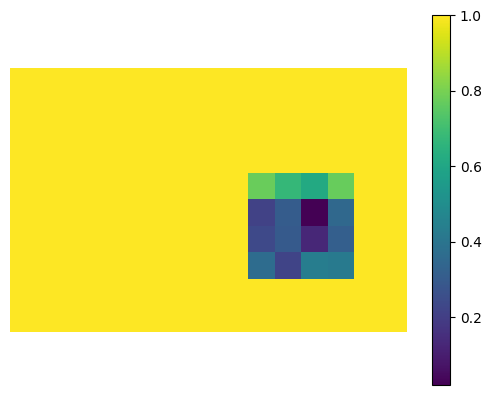

In [35]:
img = plt.imshow(csm_value, cmap='viridis')
plt.axis('off') 
plt.colorbar(img) 
plt.show()

### 2- The code for time complexity analysis

⚠️ warning ⚠️: This code takes around 40 min to complete

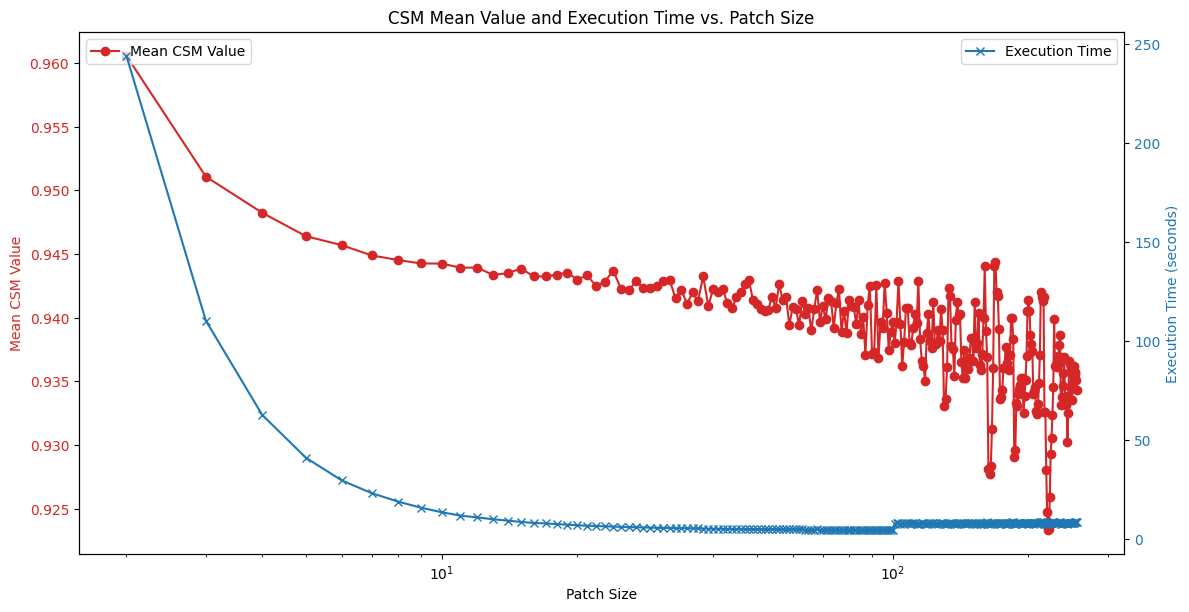

In [12]:

# Initialize arrays to store results
patch_sizes = range(256, 1, -1)  # Patch sizes from 256 down to 2
csm_means = []
execution_times = []

# Loop over different patch sizes
for patch_size in patch_sizes:
    copula_similarity = CSMSimilarity(patch_size=patch_size)
    
    # Measure start time
    start_time = time.time()
    
    # Compute CSM similarity
    csm_value = copula_similarity.compute_local_similarity(image_rgb, image_modified_rgb)
    
    # Measure end time
    end_time = time.time()
    
    # Compute mean CSM value and execution time
    csm_mean = np.mean(csm_value)
    execution_time = end_time - start_time
    
    # Store results
    csm_means.append(csm_mean)
    execution_times.append(execution_time)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot CSM mean values
color = 'tab:red'
ax1.set_xlabel('Patch Size')
ax1.set_ylabel('Mean CSM Value', color=color)
ax1.plot(patch_sizes, csm_means, color=color, marker='o', linestyle='-', label='Mean CSM Value')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.set_xticks(patch_sizes)
ax1.get_xaxis().set_major_formatter(plt.ScalarFormatter())

# Create a second y-axis to plot execution times
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Execution Time (seconds)', color=color)
ax2.plot(patch_sizes, execution_times, color=color, marker='x', linestyle='-', label='Execution Time')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xscale('log')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust layout
fig.tight_layout()
plt.title('CSM Mean Value and Execution Time vs. Patch Size')
plt.show()


### 3- Experimenting metrics on images under varying gaussian noise and blur

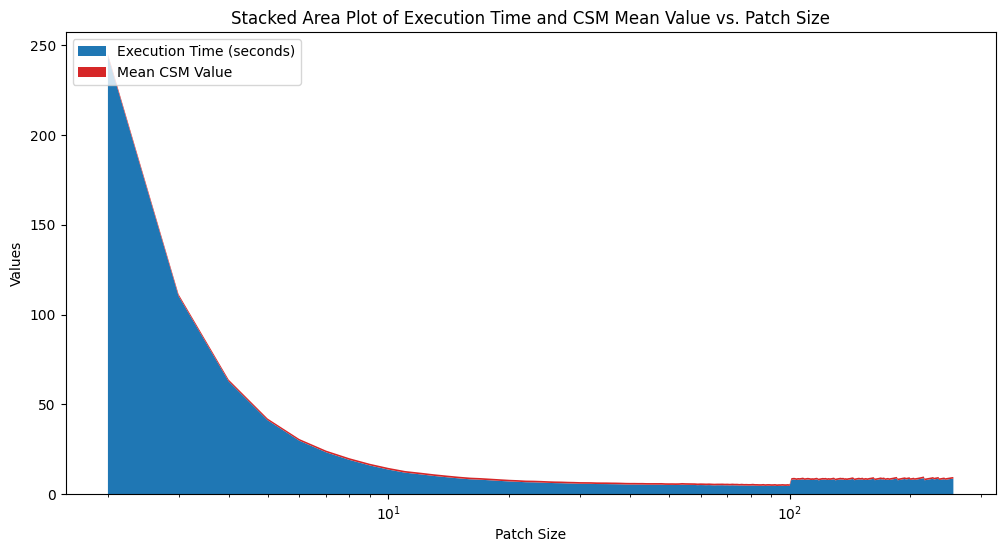

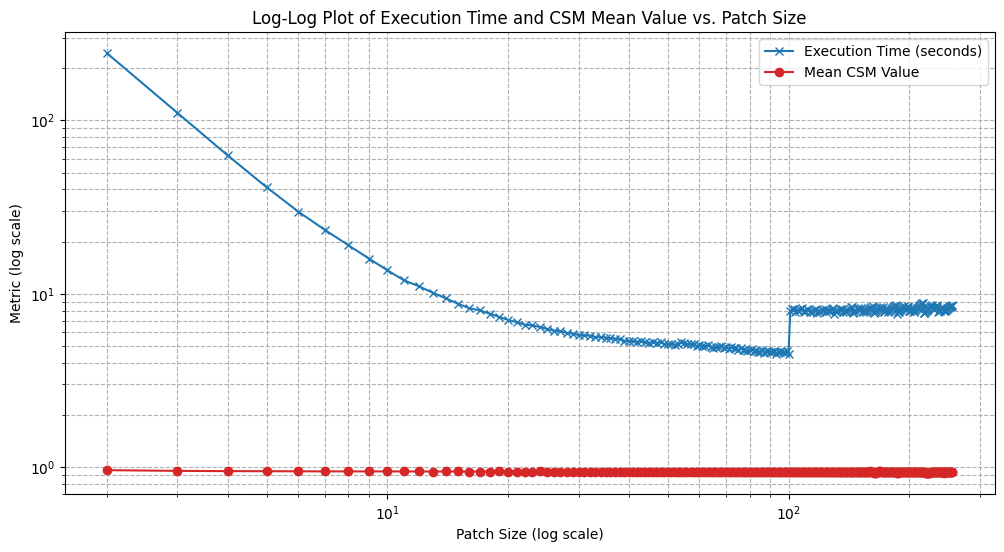

In [17]:

# Stacked area plot for Execution Time and CSM Value
plt.figure(figsize=(12, 6))
plt.stackplot(patch_sizes, execution_times, csm_means, labels=['Execution Time (seconds)', 'Mean CSM Value'], colors=['tab:blue', 'tab:red'])
plt.xlabel('Patch Size')
plt.ylabel('Values')
plt.title('Stacked Area Plot of Execution Time and CSM Mean Value vs. Patch Size')
plt.xscale('log')
plt.legend(loc='upper left')
plt.show()


# Log-Log plot for Execution Time and CSM Mean Value
plt.figure(figsize=(12, 6))
plt.loglog(patch_sizes, execution_times, marker='x', linestyle='-', color='tab:blue', label='Execution Time (seconds)')
plt.loglog(patch_sizes, csm_means, marker='o', linestyle='-', color='tab:red', label='Mean CSM Value')

plt.xlabel('Patch Size (log scale)')
plt.ylabel('Metric (log scale)')
plt.title('Log-Log Plot of Execution Time and CSM Mean Value vs. Patch Size')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()



### Save data in pickle file

In [36]:
data = {
    'patch_sizes': list(patch_sizes),
    'csm_means': csm_means,
    'execution_times': execution_times
}

with open('pkldata/csm_time_complexity_data.pkl', 'wb') as f:
    pickle.dump(data, f)

print("Data has been saved to csm_time_complexity_data.pkl")


Data has been saved to csm_time_complexity_data.pkl


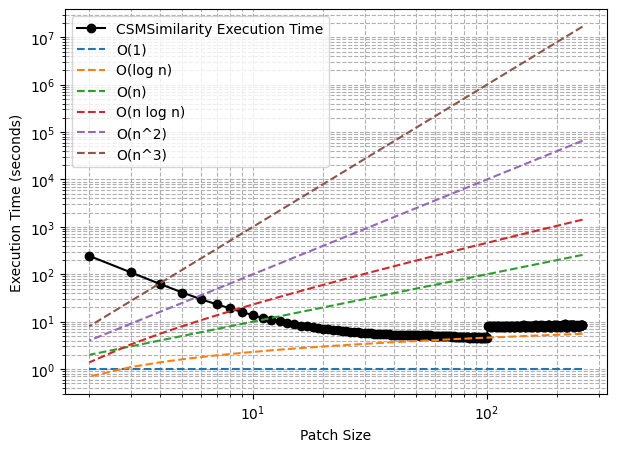

In [37]:
with open('pkldata/csm_time_complexity_data.pkl', 'rb') as f:
    data = pickle.load(f)

patch_sizes = data['patch_sizes']
csm_means = data['csm_means']
execution_times = data['execution_times']

# Define theoretical complexity functions
def constant_complexity(n):
    return np.ones_like(n)

def logarithmic_complexity(n):
    return np.log(n)

def linear_complexity(n):
    return n

def linearithmic_complexity(n):
    return n * np.log(n)

def quadratic_complexity(n):
    return n**2

def cubic_complexity(n):
    return n**3

# Convert patch sizes to numpy array for computation
patch_sizes_array = np.array(list(patch_sizes))

# Plotting
plt.figure(figsize=(7, 5))

# Plot actual execution times
plt.plot(patch_sizes_array, execution_times, label='CSMSimilarity Execution Time', marker='o', color='black')

# Plot theoretical complexities
plt.plot(patch_sizes_array, constant_complexity(patch_sizes_array), label='O(1)', linestyle='--')
plt.plot(patch_sizes_array, logarithmic_complexity(patch_sizes_array), label='O(log n)', linestyle='--')
plt.plot(patch_sizes_array, linear_complexity(patch_sizes_array), label='O(n)', linestyle='--')
plt.plot(patch_sizes_array, linearithmic_complexity(patch_sizes_array), label='O(n log n)', linestyle='--')
plt.plot(patch_sizes_array, quadratic_complexity(patch_sizes_array), label='O(n^2)', linestyle='--')
plt.plot(patch_sizes_array, cubic_complexity(patch_sizes_array), label='O(n^3)', linestyle='--')

# Customize plot
plt.xlabel('Patch Size')
plt.ylabel('Execution Time (seconds)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.savefig('complexity_analysis.pdf',format='pdf')
plt.show()
